In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Get a list of column names and types
from sqlalchemy import inspect
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Print the first row to see what the data looks like
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d5042c06d8>,
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01'}

C:\Users\Iceda\miniconda3\envs\PythonAdv\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


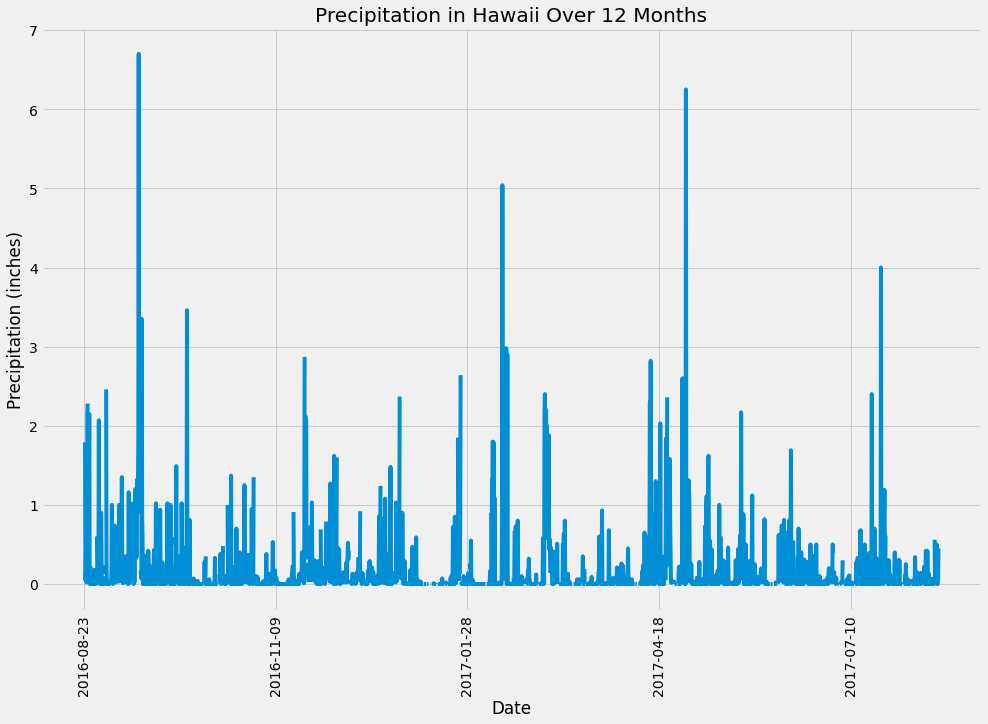

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_date = dt.datetime.strptime(last_date[0], "%Y-%m-%d").date()

query_date = last_date - dt.timedelta(days=365)
# print("Query Date: ", query_date, last_date)

# Perform a query to retrieve the data and precipitation scores
prcp= session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp, columns=['precipitation', 'date'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90, figsize=(15,10), legend = False)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation in Hawaii Over 12 Months")
plt.savefig("hawaii_precip_12_mo.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# get information about the station table
s_columns = inspector.get_columns('station')
for c in s_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Print the first row to see what the data looks like
s_first_row = session.query(Station).first()
s_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d506492940>,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [16]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
print(f"There are {stations} stations in the data set.")

# Can also just query from Measurement

There are 9 stations in the data set.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
a_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
a_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
act_station_id = a_station[0][0]

temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == act_station_id).all()

print(f"The lowest temperature recored at station {act_station_id} was {temps[0][0]}F")
print(f"The highest temperature recorded at station {act_station_id} was {temps[0][1]}F")
print(f"The average temperature recorded as station {act_station_id} was {round(temps[0][2], 1)}F")

The lowest temperature recored at station USC00519281 was 54.0F
The highest temperature recorded at station USC00519281 was 85.0F
The average temperature recorded as station USC00519281 was 71.7F


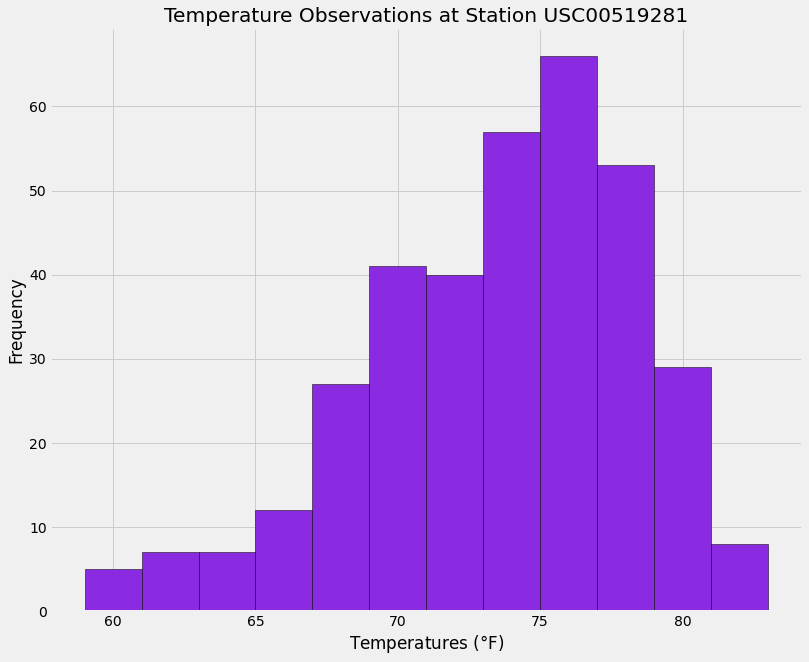

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
obs = session.query(Measurement.tobs).\
    filter(Measurement.station == act_station_id).\
    filter(Measurement.date >= query_date).all()

obs_df = pd.DataFrame(obs, columns = ['temperature'])

obs_df.plot.hist(bins=12, title = f"Temperature Observations at Station {act_station_id}",
                figsize = (12,10), ec = 'black', color = 'blueviolet', legend = False)
plt.xlabel("Temperatures ($\degree$F)")
plt.savefig("temp_obvs.png")
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

In [20]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
# Do the same for December temperature.

june_avg = session.query(Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == '06').all()

dec_avg = session.query(Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date == '12')).all()

# Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
# Will you use a paired t-test, or an unpaired t-test? Why?
from scipy import stats

t_stat, p_val = stats.ttest_ind(june_avg, dec_avg)
print(f"The calculated p-value for the June/December temperature averages is {p_val[0]}")

The calculated p-value for the June/December temperature averages is 1.6783271151877156e-60


I used an unpaired (or independent) t-test and found the p-value to be essentally zero. Thus, we can reject the null hypothesis that there is no meaningful difference in averages between June and December in Hawaii.

I chose the unpaired test because we are using two independent samples from the same population; that is, the temperature average is the population.

### Temperature Analysis II

In [21]:
trip_start = '2016-10-03'
trip_end = '2016-10-18'

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps(trip_start, trip_end)
trip_temp

[(70.0, 77.79411764705883, 82.0)]

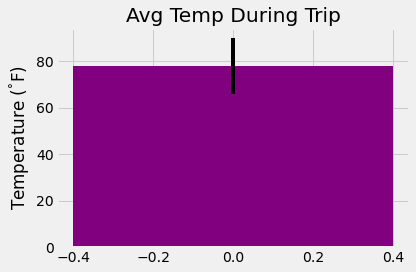

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

yerr = trip_temp[0][2]-trip_temp[0][0]
yheight = trip_temp[0][1]
plt.bar(x=0, height = yheight, yerr = yerr, color = 'purple')
plt.title('Avg Temp During Trip')
plt.ylabel('Temperature ($^\degree$F)')
plt.tight_layout()
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
tot_rain = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, 
                         func.sum(Measurement.prcp)).\
    filter(Measurement.date >= trip_start).filter(Measurement.date <= trip_end).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
tot_rain

[('USC00516128',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  57.96000000000003),
 ('USC00519281',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  5.219999999999999),
 ('USC00513117',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  1.9800000000000013),
 ('USC00514830',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  1.2600000000000005),
 ('USC00519523',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  1.2600000000000002),
 ('USC00517948',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.6300000000000001),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.09)]

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
norm_start = dt.datetime.strptime(trip_start, "%Y-%m-%d").date()
norm_end = dt.datetime.strptime(trip_end, "%Y-%m-%d").date()

norm_range = norm_end - norm_start
norm_range = norm_range.days

# Use the start and end date to create a range of dates
date_range = [norm_start + dt.timedelta(days=x) for x in range(norm_range + 1)]

# Stip off the year and save a list of %m-%d strings
md_list = [date_range[x].strftime("%m-%d") for x in range(len(date_range))]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date) for date in md_list]
# test = daily_normals(md_list[0]), daily_normals(md_list[1])
for x in range(len(normals)):
    print(normals[x][0])

(66.0, 76.73076923076923, 84.0)
(67.0, 75.86274509803921, 82.0)
(67.0, 76.16666666666667, 84.0)
(70.0, 75.42, 81.0)
(68.0, 75.6078431372549, 81.0)
(66.0, 76.3265306122449, 86.0)
(69.0, 76.11363636363636, 84.0)
(69.0, 75.85416666666667, 83.0)
(69.0, 76.57142857142857, 84.0)
(65.0, 75.75510204081633, 82.0)
(65.0, 75.98039215686275, 84.0)
(67.0, 75.1923076923077, 82.0)
(67.0, 75.63461538461539, 82.0)
(67.0, 75.59183673469387, 81.0)
(65.0, 75.07843137254902, 83.0)
(65.0, 75.0, 83.0)


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
norm_df = pd.DataFrame([])

for value in range(len(normals)):
    norm_df = norm_df.append(pd.DataFrame(normals[value], columns = ['tmin', 'tavg', 'tmax']))
    
norm_df['date'] = md_list
norm_df.set_index(norm_df['date'], inplace = True)

norm_df

,tmin,tavg,tmax,date
date,,,,
10-03,66.0,76.730769,84.0,10-03
10-04,67.0,75.862745,82.0,10-04
10-05,67.0,76.166667,84.0,10-05
10-06,70.0,75.420000,81.0,10-06
10-07,68.0,75.607843,81.0,10-07
10-08,66.0,76.326531,86.0,10-08
10-09,69.0,76.113636,84.0,10-09
10-10,69.0,75.854167,83.0,10-10
10-11,69.0,76.571429,84.0,10-11


C:\Users\Iceda\miniconda3\envs\PythonAdv\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


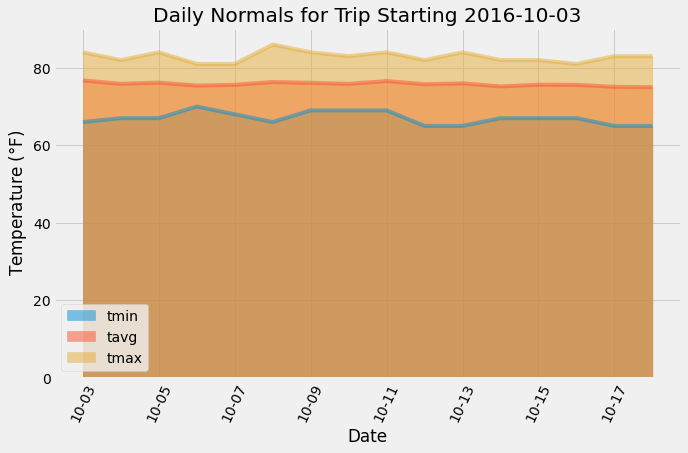

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
norm_df.plot.area(stacked=False, rot = 65, figsize=(10,6), 
                  title= f'Daily Normals for Trip Starting {trip_start}')
plt.ylabel("Temperature ($\degree$F)")
plt.xlabel("Date")
plt.savefig("daily_normals.png")
plt.show()